# Trend Following Strategy

This notebook answers question 3.4 form the text book Advances in Financial Machine Learning.

3.4 Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, the model suggests a side, but not a size of the bet.

* (a) Derive meta-labels for ptSl = [1, 2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
* (b) Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underlying model (the crossing moving average) has decided the side, {-1, 1}.

I took some liberties by extending the features to which I use to build the meta model. I also add some performance metrics at the end. 

In conclusion: Meta Labeling works, SMA strategies suck.

In [31]:
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score

from mlfinlab.corefns.core_functions import CoreFunctions
from mlfinlab.fracdiff.fracdiff import frac_diff_ffd

import matplotlib.pyplot as plt
%matplotlib inline

### Read in Data
We are using the dollar bars based off of the high quality HFT data we purchased. There is a sample of bars available in this branch as well. 

In [32]:
# Read in data
data = pd.read_csv('official_data/dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [33]:
data = data['2011-09-01':'2018-01-01']

---
### Fit a Primary Model: Trend Following
Based on the simple moving average cross-over strategy.


In [34]:
fast_window = 7
slow_window = 15

data['fast_mavg'] = data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
data['slow_mavg'] = data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
data.head()

# Compute sides
data['side'] = np.nan

long_signals = data['fast_mavg'] >= data['slow_mavg']
short_signals = data['fast_mavg'] < data['slow_mavg']
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

In [35]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [36]:
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,fast_mavg,slow_mavg,side
date_time,,,,,,,,,,
2011-09-01 14:15:02.734,1224.25,1224.75,1219.25,1219.75,57307,70010132.75,16844,1223.071429,1218.683333,1.0
2011-09-01 14:19:45.128,1219.50,1221.50,1218.00,1221.00,57382,70000958.25,16802,1224.321429,1219.033333,1.0
2011-09-01 14:28:51.391,1221.00,1223.75,1220.50,1221.75,57280,70004186.50,16969,1223.750000,1219.816667,1.0
2011-09-01 14:35:33.745,1221.75,1222.00,1216.25,1216.50,57439,70000686.25,16636,1222.250000,1220.083333,1.0
2011-09-01 14:44:47.388,1216.50,1221.75,1216.25,1220.75,57416,70000964.25,17178,1221.285714,1220.416667,1.0


In [8]:
data['side'].value_counts()

 1.0    35703
-1.0    31736
Name: side, dtype: int64

### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [9]:
# Compute daily volatility
daily_vol = CoreFunctions.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = CoreFunctions.get_t_events(data['close'], threshold=daily_vol.mean())

# Compute vertical barrier
vertical_barriers = CoreFunctions.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

  0%|          | 0/67437 [00:00<?, ?it/s]

Calculating daily volatility for dynamic thresholds
Applying Symmetric CUSUM filter.


100%|██████████| 67437/67437 [00:14<00:00, 4691.10it/s]


In [10]:
pt_sl = [1, 2]
triple_barrier_events = CoreFunctions.get_events(close=data['close'],
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=0.01,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers,
                                  side=data['side'])

/home/ariadne/Desktop/Research Project/research/2019-03-03_AS_JJ_Chapter3/mlfinlab/corefns/core_functions.py:205: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-03-06 18:07:41.922351 100.0% apply_pt_sl_on_t1 done after 0.03 minutes. Remaining 0.0 minutes.


In [12]:
labels = CoreFunctions.get_bins(triple_barrier_events, data['close'])

---
### Results of Primary Model:
What is the accuracy of predictions from the primary model (i.e., if the sec- ondary model does not filter the bets)? What are the precision, recall, and F1-scores?

In [16]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       490
           1       0.37      1.00      0.54       285

   micro avg       0.37      0.37      0.37       775
   macro avg       0.18      0.50      0.27       775
weighted avg       0.14      0.37      0.20       775

Confusion Matrix
[[  0 490]
 [  0 285]]

Accuracy
0.36774193548387096


/home/ariadne/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
## Fit a Meta Model
Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

Create the following features: 
* Volatility
* Serial Correlation
* The returns at the different lags from the serial correlation
* The sides from the SMavg Strategy

In [17]:
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,fast_mavg,slow_mavg,side
date_time,,,,,,,,,,
2011-09-01 06:08:14.750,1217.50,1224.50,1216.5,1220.00,57388,70028257.0,19018,NaN,NaN,NaN
2011-09-01 07:48:09.398,1220.00,1224.50,1215.5,1215.75,57394,70005670.5,20160,NaN,NaN,NaN
2011-09-01 09:13:14.311,1215.75,1216.50,1209.5,1210.00,57691,70000560.5,21107,NaN,NaN,NaN
2011-09-01 10:51:49.085,1210.00,1213.50,1208.5,1212.50,57801,70003237.5,17728,NaN,NaN,NaN
2011-09-01 12:23:59.756,1212.50,1216.75,1210.5,1215.75,57656,70000722.0,19398,NaN,NaN,NaN


### Features

In [18]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

In [20]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [21]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

#### Now get the data at the specified events

In [23]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']

### Fit a model

In [24]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, shuffle=False)

In [25]:
# Random Forest Model
n_estimator = 50
c_random_state = 42
depth = 9

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#### Training Metrics

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       125
           1       1.00      0.99      1.00       107

   micro avg       1.00      1.00      1.00       232
   macro avg       1.00      1.00      1.00       232
weighted avg       1.00      1.00      1.00       232

Confusion Matrix
[[125   0]
 [  1 106]]

Accuracy
0.36774193548387096


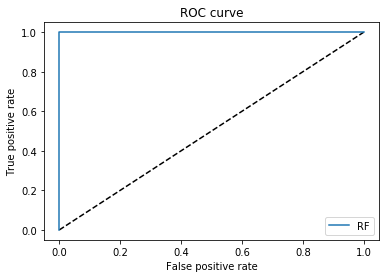

In [26]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

This is overfitting big time but I'll leave the hyper param tuning to other enthusiast. 

#### Test Metrics

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       365
           1       0.40      0.44      0.42       178

   micro avg       0.60      0.60      0.60       543
   macro avg       0.55      0.56      0.56       543
weighted avg       0.61      0.60      0.60       543

Confusion Matrix
[[245 120]
 [ 99  79]]

Accuracy
0.36774193548387096


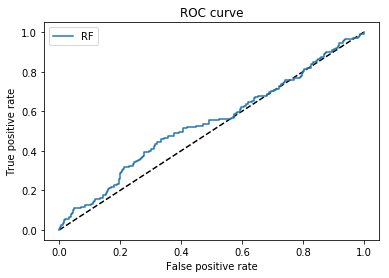

In [27]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

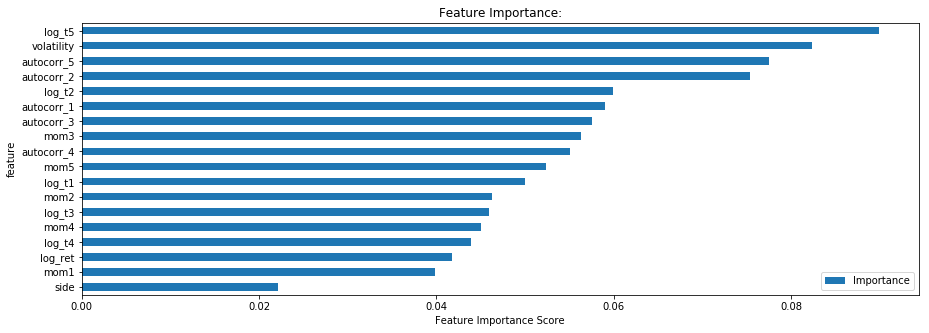

In [37]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

Note how low the side is ranked. If we look at the performance of the primary model we will see that the SMA strategy gets only 36% of the trades correct.

---
## Performance Tear Sheets

In [29]:
test_dates = X_test.index

print(pf.show_perf_stats(labels.loc[test_dates, 'ret']))
print(pf.show_worst_drawdown_periods(labels.loc[test_dates, 'ret']))

Start date,2011-10-14
End date,2016-11-10
Total months,25
,Backtest
Annual return,-17.1%
Cumulative returns,-33.3%
Annual volatility,23.4%
Sharpe ratio,-0.69
Calmar ratio,-0.40
Stability,0.73
Max drawdown,-42.3%


None


/home/ariadne/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,42.34,2011-10-14,2016-11-09,NaT,NaN
1,0.00,2011-10-14,2011-10-14,2011-10-14,1
2,0.00,2011-10-14,2011-10-14,2011-10-14,1
3,0.00,2011-10-14,2011-10-14,2011-10-14,1
4,0.00,2011-10-14,2011-10-14,2011-10-14,1


None


In [30]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred

print(pf.show_perf_stats(meta_returns))
print(pf.show_worst_drawdown_periods(meta_returns))

Start date,2011-10-14
End date,2016-11-10
Total months,25
,Backtest
Annual return,2.6%
Cumulative returns,5.6%
Annual volatility,14.9%
Sharpe ratio,0.25
Calmar ratio,0.10
Stability,0.01
Max drawdown,-26.0%


None


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.04,2011-10-20,2015-08-25,2016-02-25,1136
1,7.92,2016-11-09,2016-11-09,2016-11-09,1
2,6.01,2011-10-17,2011-10-18,2011-10-20,4
3,5.72,2016-11-09,2016-11-09,NaT,NaN
4,0.00,2011-10-14,2011-10-14,2011-10-14,1


None


---
## Conclusion
It would seem that the biggest problem here is the moving average strategy. It is not a good signal!

You can play around with the model and the metrics. Interesting to see the difference if you shuffel the data vs not. 

Its great to see in this notebook that meta labeling helped to improve the portfolio's performance metrics by reducing the drawdown and increaseing the returns from -17% to a 2.6%